### Adam,  Sgdm with Tree Aggregate Implementation in PySpark
### Author: 
* Yi Rong (yirong@bu.edu)
* Xiaoyang Wang (gnayoaix@bu.edu)

### Date: 05/13/2021

In [1]:
from __future__ import print_function
import sys

from operator import add
# from string import lowercase
from re import sub, search
import numpy as np
from numpy.random.mtrand import dirichlet, multinomial
from string import punctuation
import random
import time
from scipy.stats import norm
import pandas as pd
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from pandas import DataFrame
import matplotlib.cm as cm
from random import sample

from pyspark.sql import functions as f, udf
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.context import SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.mllib.stat import Statistics
from numpy.linalg import multi_dot
from scipy.stats import multivariate_normal
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

In [2]:
# sc = SparkContext(appName="optimizer")

### Generate Data with make_blobs

In [3]:
n_feature = 2 # the number of features
n_components = 2 # the number of clusters

max_iter = 300 # max iterations 
n=10000 # the number of total samples

In [4]:
# generate isotropic Gaussian blobs (data from mixture Gaussian distributions)
X, y = make_blobs(n_samples=n, # the number of total samples
                  centers=n_components, # the number of clusters
                  n_features=n_feature, # the number of features
                  random_state=14) # 2

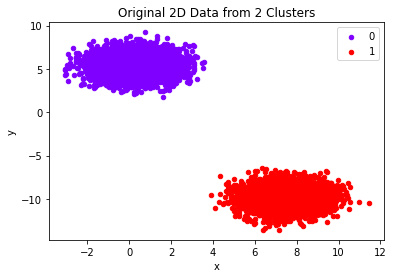

In [5]:
# scatter plot, data points annotated by different colors
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
cluster_name = set(y)
colors = dict(zip(cluster_name, cm.rainbow(np.linspace(0, 1, len(cluster_name)))))
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key].reshape(1,-1))
pyplot.title('Original 2D Data from {} Clusters'.format(n_components))
pyplot.show()

### Train a Logistic Regression Model

In [6]:
# read X, y into rdd
rdd_X = sc.parallelize(X)
rdd_y = sc.parallelize(y)

# split data into train and test
traindata, testdata = rdd_y.zip(rdd_X).randomSplit([0.7, 0.3], seed=12345)
traindata.cache()

PythonRDD[3] at RDD at PythonRDD.scala:53

In [7]:
train_size = traindata.count()

# TODO
add math for Adam and others 

# Also others 



In [8]:
def LogisticRegression(traindata=traindata,
                       max_iteration = max_iter,
                       learningRate = 0.01,
                       regularization = 0.01,
                       mini_batch_size = 256,
                       tolerance = 0.00001,
                       optimizer = 'None'  #optimizer: 'SGDM' / 'Adam' / 'None'
                      ):

    # initialization
    prev_cost = 0
    L_cost = []
    prev_validation = 0
    train_size = traindata.count()

    parameter_size = len(traindata.take(1)[0][1]) + 1
    np.random.seed(0)
    parameter_vector = np.random.normal(0, 0.1, parameter_size)

    momentum = np.zeros(parameter_size)
    history = np.array(parameter_size)

    for i in range(max_iteration):

        bc_weights = sc.broadcast(parameter_vector[:-1])
        bc1_weights = sc.broadcast(parameter_vector[-1])

        min_batch = traindata.sample(False, mini_batch_size / train_size, 1 + i)

        res = min_batch.treeAggregate((np.zeros(parameter_size), 0, 0),\
              lambda x, y:(x[0]\
                          + (np.append(y[1], 1)) * (-y[0] + (np.exp(np.dot(y[1], bc_weights.value) + bc1_weights.value)\
                          /(1 + np.exp(np.dot(y[1], bc_weights.value) + bc1_weights.value)))),\
                          x[1] \
                          + y[0] * (-(np.dot(y[1], bc_weights.value) + bc1_weights.value)) \
                          + np.log(1 + np.exp(np.dot(y[1],bc_weights.value)+ bc1_weights.value)),\
                          x[2] + 1),
              lambda x, y:(x[0] + y[0], x[1] + y[1], x[2] + y[2]))

        cost =  res[1] + regularization * (np.square(parameter_vector).sum())

        # calculate gradients
        gradient_derivative = (1.0 / res[2]) * res[0] + 2 * regularization * parameter_vector

        if optimizer == 'None':
            parameter_vector = parameter_vector - learningRate * gradient_derivative

        if optimizer =='SGDM':
            beta = 0.9
            momentum = beta * momentum + (1 - beta) * gradient_derivative
            parameter_vector = parameter_vector - learningRate * momentum
            
        if optimizer == 'Adam':
            beta1 = 0.9
            beta2 = 0.999
            epsilon = 10e-8
            momentum = beta1 * momentum + (1 - beta1) * gradient_derivative
            history = beta2 * history + (1-beta2) * (gradient_derivative**2)
            momentum = momentum / (1 - beta1**(i + 1))
            history = history / (1 - beta2**(i + 1))
            parameter_vector = parameter_vector - learningRate * momentum / ((history)**0.5 + epsilon)


        if i%20 == 0 :
            print("Iteration No.", i, " Cost=", cost)

        # Stop if the cost is not descreasing
        if abs(cost - prev_cost) < tolerance:
            print("cost - prev_cost: " + str(cost - prev_cost))
            break
        prev_cost = cost
        L_cost.append(cost)
        
    return parameter_vector, L_cost

### Model Evaluation

#### None Optimizer

In [9]:
parameter_vector_no, L_cost_no = LogisticRegression(traindata=traindata,
                       max_iteration = max_iter,
                       learningRate = 0.01,
                       regularization = 0.01,
                       mini_batch_size = 512,
                       tolerance = 10e-6,
                       optimizer = 'None'  #optimizer: 'SGDM' / 'Adam' / 'None'
                      )

Iteration No. 0  Cost= 323.6520273649225
Iteration No. 20  Cost= 76.32814921691427
Iteration No. 40  Cost= 46.046709236892376
Iteration No. 60  Cost= 29.468810370776904
Iteration No. 80  Cost= 20.94042609408585
Iteration No. 100  Cost= 19.791120843433582
Iteration No. 120  Cost= 16.150674109177253
Iteration No. 140  Cost= 14.93829784635836
Iteration No. 160  Cost= 12.997378319115146
Iteration No. 180  Cost= 11.938434921277997
Iteration No. 200  Cost= 10.323929214842227
Iteration No. 220  Cost= 9.214256123916094
Iteration No. 240  Cost= 9.553043413269112
Iteration No. 260  Cost= 8.840224790056595
Iteration No. 280  Cost= 7.259039279416286


confusion matrix: (1527, 0, 0, 1462)
f1 score: 1.0


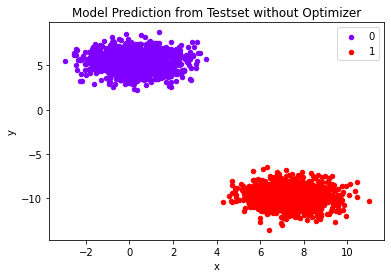

In [10]:
# check parameter_vector * x[1] is positive (label 1) or negative (label 0), x[0] is the actual label
rdd2 = testdata.map(lambda x: (np.dot(np.append(x[1], [1]), parameter_vector_no), x[0])) \
    .map(lambda x: (np.where(x[0] >= 0, 1, 0), x[1])) \

# get confusion matrix result for each row: (TN, FP, FN, TP), 1 for true, 0 for false
rdd3 = rdd2.map(lambda x: (
np.where(x[0] == 0 and x[1] == 0, 1, 0), np.where(x[0] == 1 and x[1] == 0, 1, 0),  # confusion matrix
np.where(x[0] == 0 and x[1] == 1, 1, 0), np.where(x[0] == 1 and x[1] == 1, 1, 0)))

# calculate f1 score
cmat = rdd3.reduce(lambda x, y: (x[0] + y[0], x[1] + y[1], x[2] + y[2], x[3] + y[3]))
print("confusion matrix: " + str(cmat))
TN, FP, FN, TP = cmat[0], cmat[1], cmat[2], cmat[3]

if TP + FP != 0 and TP + FN != 0:
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)

    f1score = 2 * precision * recall / (precision + recall)
else:
    f1score = 0

print("f1 score: " + str(f1score))

# prediction on test set
y_pred = rdd2.map(lambda x: int(x[0])).collect()
X_test = np.array(testdata.map(lambda x: x[1]).collect())

# scatter plot, data points annotated by different colors
df = DataFrame(dict(x=X_test[:,0], y=X_test[:,1], label=y_pred))
cluster_name = set(y)
colors = dict(zip(cluster_name, cm.rainbow(np.linspace(0,1,len(cluster_name)))))
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key].reshape(1,-1))
pyplot.title('Model Prediction from Testset without Optimizer'.format(n_components))
pyplot.show()

#### Adam

In [11]:
parameter_vector_adam, L_cost_adam = LogisticRegression(traindata=traindata,
                       max_iteration = max_iter,
                       learningRate = 0.01,
                       regularization = 0.01,
                       mini_batch_size = 512,
                       tolerance = 10e-6,
                       optimizer = 'Adam'  #optimizer: 'SGDM' / 'Adam' / 'None'
                      )



Iteration No. 0  Cost= 323.6520273649225
Iteration No. 20  Cost= 308.2985507449888
Iteration No. 40  Cost= 307.7829688027519
Iteration No. 60  Cost= 277.21053420891167
Iteration No. 80  Cost= 278.27940058379045
Iteration No. 100  Cost= 308.3279037939711
Iteration No. 120  Cost= 308.2320595960131
Iteration No. 140  Cost= 322.37065788534306
Iteration No. 160  Cost= 307.9660584674751
Iteration No. 180  Cost= 325.07285882744264
Iteration No. 200  Cost= 312.95626304229063
Iteration No. 220  Cost= 289.5844846225656
Iteration No. 240  Cost= 306.42586352908563
Iteration No. 260  Cost= 309.28351857977344
Iteration No. 280  Cost= 297.0141488337683


confusion matrix: (33, 1494, 0, 1462)
f1 score: 0.6618379357175193


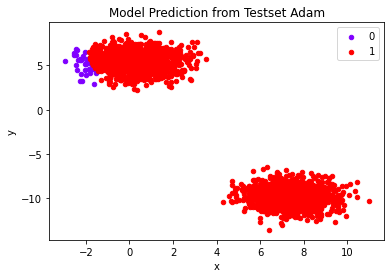

In [12]:
# check parameter_vector * x[1] is positive (label 1) or negative (label 0), x[0] is the actual label
rdd2 = testdata.map(lambda x: (np.dot(np.append(x[1], [1]), parameter_vector_adam), x[0])) \
    .map(lambda x: (np.where(x[0] >= 0, 1, 0), x[1])) \

# get confusion matrix result for each row: (TN, FP, FN, TP), 1 for true, 0 for false
rdd3 = rdd2.map(lambda x: (
np.where(x[0] == 0 and x[1] == 0, 1, 0), np.where(x[0] == 1 and x[1] == 0, 1, 0),  # confusion matrix
np.where(x[0] == 0 and x[1] == 1, 1, 0), np.where(x[0] == 1 and x[1] == 1, 1, 0)))

# calculate f1 score
cmat = rdd3.reduce(lambda x, y: (x[0] + y[0], x[1] + y[1], x[2] + y[2], x[3] + y[3]))
print("confusion matrix: " + str(cmat))
TN, FP, FN, TP = cmat[0], cmat[1], cmat[2], cmat[3]

if TP + FP != 0 and TP + FN != 0:
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)

    f1score = 2 * precision * recall / (precision + recall)
else:
    f1score = 0

print("f1 score: " + str(f1score))

# prediction on test set
y_pred = rdd2.map(lambda x: int(x[0])).collect()
X_test = np.array(testdata.map(lambda x: x[1]).collect())

# scatter plot, data points annotated by different colors
df = DataFrame(dict(x=X_test[:,0], y=X_test[:,1], label=y_pred))
cluster_name = set(y)
colors = dict(zip(cluster_name, cm.rainbow(np.linspace(0,1,len(cluster_name)))))
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key].reshape(1,-1))
pyplot.title('Model Prediction from Testset Adam'.format(n_components))
pyplot.show()

#### SGDM

In [ ]:
parameter_vector_sgdm, L_cost_sgdm = LogisticRegression(traindata=traindata,
                       max_iteration = max_iter,
                       learningRate = 0.01,
                       regularization = 0.01,
                       mini_batch_size = 512,
                       tolerance = 10e-6,
                       optimizer = 'SGDM'  #optimizer: 'SGDM' / 'Adam' / 'None'
                      )

Iteration No. 0  Cost= 323.6520273649225
Iteration No. 20  Cost= 86.63297138387414
Iteration No. 40  Cost= 39.51313660594664
Iteration No. 60  Cost= 24.077093582998653
Iteration No. 80  Cost= 17.179660880837275
Iteration No. 100  Cost= 16.543771920995653
Iteration No. 120  Cost= 13.76888259195989
Iteration No. 140  Cost= 12.937829749197679


In [ ]:
# check parameter_vector * x[1] is positive (label 1) or negative (label 0), x[0] is the actual label
rdd2 = testdata.map(lambda x: (np.dot(np.append(x[1], [1]), parameter_vector_sgdm), x[0])) \
    .map(lambda x: (np.where(x[0] >= 0, 1, 0), x[1])) \

# get confusion matrix result for each row: (TN, FP, FN, TP), 1 for true, 0 for false
rdd3 = rdd2.map(lambda x: (
np.where(x[0] == 0 and x[1] == 0, 1, 0), np.where(x[0] == 1 and x[1] == 0, 1, 0),  # confusion matrix
np.where(x[0] == 0 and x[1] == 1, 1, 0), np.where(x[0] == 1 and x[1] == 1, 1, 0)))

# calculate f1 score
cmat = rdd3.reduce(lambda x, y: (x[0] + y[0], x[1] + y[1], x[2] + y[2], x[3] + y[3]))
print("confusion matrix: " + str(cmat))
TN, FP, FN, TP = cmat[0], cmat[1], cmat[2], cmat[3]

if TP + FP != 0 and TP + FN != 0:
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)

    f1score = 2 * precision * recall / (precision + recall)
else:
    f1score = 0

print("f1 score: " + str(f1score))

# prediction on test set
y_pred = rdd2.map(lambda x: int(x[0])).collect()
X_test = np.array(testdata.map(lambda x: x[1]).collect())

# scatter plot, data points annotated by different colors
df = DataFrame(dict(x=X_test[:,0], y=X_test[:,1], label=y_pred))
cluster_name = set(y)
colors = dict(zip(cluster_name, cm.rainbow(np.linspace(0,1,len(cluster_name)))))
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key].reshape(1,-1))
pyplot.title('Model Prediction from Testset SGDM'.format(n_components))
pyplot.show()

### Optimizers Comparison

In [ ]:
# Data
df = pd.DataFrame({'iteration': range(1, max_iter+1), 
                 'cost_sgdm': L_cost_sgdm, 
                 'cost_adam': L_cost_adam, 
                 'cost_no': L_cost_no })
 
# multiple line plots
pyplot.plot( 'iteration', 'cost_sgdm', data=df, marker='', color='skyblue', linewidth=2)
pyplot.plot( 'iteration', 'cost_adam', data=df, marker='', color='red', linewidth=2)
pyplot.plot( 'iteration', 'cost_no', data=df, marker='', color='green', linewidth=2)
# show legend
pyplot.legend()
pyplot.title('Cost Comparison among SGDM, Adam, no optimizer')
# show graph
pyplot.show()

### F1 Score Comparison

* SGDM: 0.901
* Adam: 0.960
* No: 0.901